<a href="https://colab.research.google.com/github/mobarakol/computer_vision_tutorial/blob/main/3d_bbox_visualization_naive_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#3D bbox drawing from naive annotation

In [1]:
import gdown
url = 'https://drive.google.com/uc?id=15uNc-QgcDAWIglEMDaW_WGCVYnwZEXH6'
gdown.download(url,'To_visulize.zip',quiet=True) 
!unzip -q To_visulize.zip

PrograspForceps xmin,ymin,xmax,ymax: 660 -482 2204 455
reproject cen: [[1104.57314693  185.40096524]]
BipolarForceps xmin,ymin,xmax,ymax: -40639 -11931 639 4513
reproject cen: [[ 14.42425561 373.68403217]]
others xmin,ymin,xmax,ymax: -950 237 1811 862
reproject cen: [[566.56224238 518.37057741]]


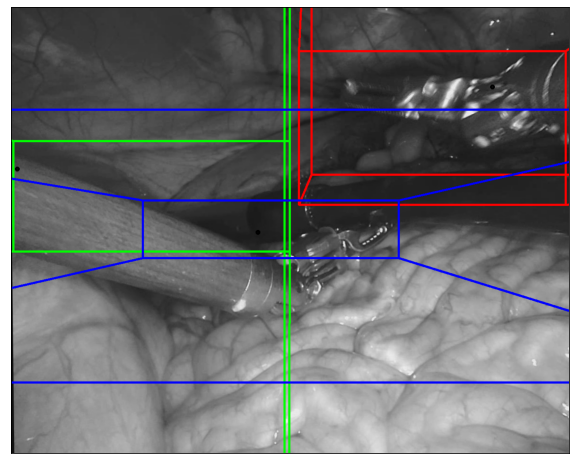

In [10]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# this code is used to visulize dataset
# mainly change three variables of path:
# matric_path
# dim_path
# img_path
# the example files are also provided
# matric_path means the matric file which is in calib folder
# dim_path means the path to label file which is in label folder
# img_path means the path to image file which is in image folder
draw_3d = True

# change this bool variable to change visualization type
# but as the remarks explain later
# the visulization results maybe no different

#matric_path = r'C:\Users\conor\labeltool\instrument_dataset_1\matric.txt'
matric_path = r'To_visulize/calib/frame0000.txt'
with open(matric_path,'r') as Matric:
    Mlines = Matric.readlines()
P1_str = Mlines[0].strip().split(' ')[1:]
P1 = np.array(P1_str,dtype=np.float32)
P1 = P1.reshape(3,4)

DIM = {}
#dim_path = r'C:\Users\conor\labeltool\instrument_dataset_1\label_dims\frame000.txt'
#dim_path = r'C:\Users\conor\MyPythonCode\frame000.txt'
dim_path = r'To_visulize/label/frame0000.txt'
with open(dim_path,'r') as Dim:
    Dimlines = Dim.readlines()

for dims in Dimlines:
    dim = dims.strip().split(' ')
    instru = ''
    HWL = []
    for data in dim:
        try:
            HWL.append(float(data))
        except ValueError:
            instru += data
    DIM[instru] = HWL
#print(DIM)

img_path = r'To_visulize/image/frame0000.png'
img = cv2.imread(img_path)

for key,value in DIM.items():
    inscls = key
    bbox_xyxy = value[0:4]
    cen = [(bbox_xyxy[0]+bbox_xyxy[2])/2 , (bbox_xyxy[1]+bbox_xyxy[3])/2]
    #print('cen',cen)
    loca = value[4:7] #X,Y,Z
    dime = value[7:10] #W,L,H
    Xleft = loca[0] - dime[0] / 2
    Xright = loca[0] + dime[0] / 2
    Yforw = loca[1] + dime[1] / 2
    Yback = loca[1] - dime[1] / 2
    Zup = loca[2] + dime[2] / 2
    Zdown = loca[2] - dime[2] /2
    
    loca_homo = np.vstack([np.array(loca).reshape(3,1),[1]])
    procen = np.dot(P1,loca_homo)
    recen = procen[0:2] / procen[2]
    recen_int = [int(recen[0]),int(recen[1])]
    cv2.circle(img,recen_int,3,(0,0,0),3)

    ALLX = np.array([Xleft] * 4 + [Xright] * 4)
    ALLY = np.array(([Yforw] * 2 + [Yback] * 2) * 2)
    ALLZ = np.array([Zup,Zdown] * 4)
    one = np.ones((1,8))
    Points = np.vstack([ALLX,ALLY,ALLZ,one])
    points = np.dot(P1,Points)
    
    ptimg = []
    x = []
    y = []
    # here since we don't have the rotation angle and we assume every object is parallel to the axis
    # x and y will get 8 elements but with repetation and only 4 values are actually result
    # this can be checked from the print output labeled with x: and y:
    # because we can only get 4 coordinates of pixels in image, the result of visulization of 3d bbox on images looks as same as 2d bbox
    for i in range(points.shape[1]):
        uv_ = points[:,i]
        uv = uv_[0:2] / uv_[2]
        u = uv[0]
        v = uv[1]
        x.append(float(u))
        y.append(float(v))
        ptimg.append([int(u),int(v)])
    
    '''
    #these four lines is to limit the values of the calculation results within the image resolution 1280x1024
    xmax = int(min(max(x),1279))
    xmin = int(max(min(x),0))
    ymax = int(min(max(y),1023))
    ymin = int(max(min(y),0))'''
    
    #These four lines directly use the calculation results which maybe too large to draw 2d bbox
    xmax = int(max(x))
    xmin = int(min(x))
    ymax = int(max(y))
    ymin = int(min(y))
    #print('x:',x)
    #print('y:',y)
    #print('ptimg:',ptimg)
    print(inscls,'xmin,ymin,xmax,ymax:',xmin,ymin,xmax,ymax)
    print('reproject cen:',recen.reshape(1,2))
    #BGR
    color = {
        'PrograspForceps':(255,0,0),#B
        'BipolarForceps':(0,255,0),#G
        'Others':(0,0,255),#R
        'others':(0,0,255),#R
        'LargeNeedleDriver':(255,255,0),#BG-->
        'VesselSealer':(255,0,255),#BR-->
        'GraspingRetractor':(0,255,255),#GR-->
        'MonopolarCurvedScissors':(255,255,255) #White
    }
    
    if not draw_3d:
        cv2.rectangle(img,(xmin,ymin),(xmax,ymax),color[inscls],3)
    
    if draw_3d:
        #'''
        # this is used to draw rectangles but the effect is poor
        cv2.line(img,ptimg[0],ptimg[1],color[inscls],3)
        cv2.line(img,ptimg[0],ptimg[2],color[inscls],3)
        cv2.line(img,ptimg[0],ptimg[4],color[inscls],3)
        cv2.line(img,ptimg[1],ptimg[3],color[inscls],3)
        cv2.line(img,ptimg[1],ptimg[5],color[inscls],3)
        cv2.line(img,ptimg[2],ptimg[3],color[inscls],3)
        cv2.line(img,ptimg[2],ptimg[6],color[inscls],3)
        cv2.line(img,ptimg[3],ptimg[7],color[inscls],3)
        cv2.line(img,ptimg[4],ptimg[5],color[inscls],3)
        cv2.line(img,ptimg[4],ptimg[6],color[inscls],3)
        cv2.line(img,ptimg[5],ptimg[7],color[inscls],3)
        cv2.line(img,ptimg[6],ptimg[7],color[inscls],3)
        #'''

        # for pt in ptimg:
        #     # this is used to draw reprojection points
        #     # idealy it should draw 8 points for each 
        #     # but it always can not get ideal outputs
        #     cv2.circle(img,(int(pt[0]),int(pt[1])),3,color[inscls],3)

num_img = 1
fig, ax = plt.subplots(1, num_img, figsize=(10,5*2), subplot_kw=dict(xticks=[],yticks=[]))
ax.imshow(img)
# cv2_imshow(img)
